# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

In [1]:
import numpy as np
from glob import glob
import cv2                
import matplotlib.pyplot as plt
#from tqdm import tqdm

import torch
from torch import __version__
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

from PIL import Image
from PIL import ImageFile

import os
import gc

%matplotlib inline

# use this to temporarily address crashes due to matplotlib and OpenMP
# "OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized."
# see https://knowledge.udacity.com/questions/782100
os.environ['KMP_DUPLICATE_LIB_OK']='True'

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [2]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
#  Borrowed from the Machine Larning Capstone that I completed last year

# define training and test data directories
data_dir = 'landmark_images/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 16 #20  changed from 20 to 16 due to experience with the following error when running locally on gpu
                #    RuntimeError: CUDA error: CUBLAS_STATUS_ALLOC_FAILED when calling `cublasCreate(handle)
                #    see https://knowledge.udacity.com/questions/782100
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform_train = transforms.Compose([
    #transforms.RandomResizedCrop(224), # REMOVE LATER
    transforms.Resize(size=[224,224]),
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])

transform_valid = transforms.Compose([
    #transforms.Resize(size=[256,256]), # REMOVE LATER
    #transforms.CenterCrop(224),        # REMOVE LATER
    transforms.Resize(size=[224,224]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])

transform_test = transforms.Compose([
    #transforms.Resize(size=[256,256]), # REMOVE LATER
    #transforms.CenterCrop(224),        # REMOVE LATER
    transforms.Resize(size=[224,224]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])

# choose the training and test datasets NOTE TO SELF, UPDATE ROOT
train_data = datasets.ImageFolder(train_dir, transform=transform_train)
valid_data = datasets.ImageFolder(train_dir, transform=transform_valid)
test_data  = datasets.ImageFolder(test_dir, transform=transform_test)

# define samplers for obtaining training and validation batches
# since we do not have a seperate valid directory, we will use a subset of training data
num_train = len(train_data)                             # get number of training images
split     = int(np.floor(valid_size*num_train))         # find the split point between train_data and valid_data
indices   = list(range(num_train))                      # compile a list of indices of train_data
np.random.shuffle(indices)                              # shuffle the indices
train_idx, valid_idx = indices[split:], indices[:split] # split the indices into train and valid
train_sampler = SubsetRandomSampler(train_idx)          # sampler for train
valid_sampler = SubsetRandomSampler(valid_idx)          # sampler for valid

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size,
                                           sampler=train_sampler, 
                                           num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, 
                                           batch_size=batch_size, 
                                           sampler=valid_sampler, 
                                           num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size, 
                                          num_workers=num_workers)

loaders_scratch = {'train': train_loader,
                  'valid': valid_loader,
                  'test': test_loader}

**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 

I am using the exact same approach I used for the dog breed classificaiton project in Machine Learning Engineer. Since this project is another image classification project, I should be able to use the same methodology.

Training images are resized to 224x224 because it is the input size of the VGG model.

Training images are augmented by random horizontal flipping and random rotation. These random augmentations should minimize image orientation as a detectable feature.

Validation and Test images are resized 224x224. Augmentation is not used on either.

Finally, all dataset images are normalized.

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


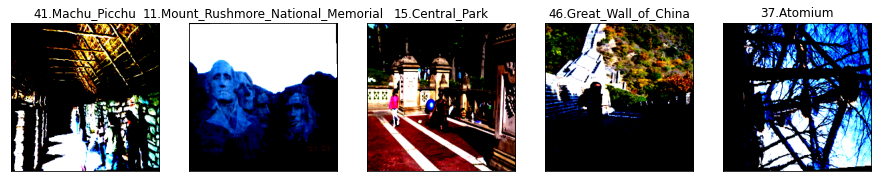

In [3]:
#import matplotlib.pyplot as plt  # moved to top
#%matplotlib inline


## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

# Visualize some sample data

num_images_to_display = 5

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(num_images_to_display): # 20
    ax = fig.add_subplot(1, 8, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(train_data.classes[labels[idx]])

### Initialize use_cuda variable

In [4]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

if not use_cuda:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [5]:
## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    return optim.SGD(model_scratch.parameters(), lr=0.05) # from dog_app (Machine Learning Engineer)   

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [6]:
#import torch.nn as nn   # moved to top

# Borrowed from the Machine Larning Capstone that I completed last year

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)

        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # linear layer (256 * 7 * 7 -> 256 * 2 * 2)
        self.fc1 = nn.Linear(256 * 7 * 7, 256 * 2 * 2 )
        # linear layer (256 * 2 * 2 -> 133)
        self.fc2 = nn.Linear(256 * 2 * 2, 133)
        
        # dropout layers 
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.15)
        self.dropout3 = nn.Dropout(0.2)
        self.dropout4 = nn.Dropout(0.25)
        self.dropout5 = nn.Dropout(0.3)
                              
    def forward(self, x):
        ## Define forward behavior
        
        # convolution, maxpooling, and dropout
        x = self.pool(F.relu(self.conv1(x))) # 112x112x16
        #x = self.dropout1(x)                 
        x = self.pool(F.relu(self.conv2(x))) # 56x56x32
        #x = self.dropout2(x)
        x = self.pool(F.relu(self.conv3(x))) # 28x28x64
        #x = self.dropout3(x)
        x = self.pool(F.relu(self.conv4(x))) # 14x14x128 
        #x = self.dropout4(x)
        x = self.pool(F.relu(self.conv5(x))) # 7x7x256
        x = self.dropout5(x)

        # flatten
        x = x.view(-1,256 * 7 * 7)
        
        # hidden layers
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
             
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  
I am using the exact same model I used for the dog breed classificaiton project in Machine Learning Engineer. Since this project is another image classification project, I should be able to use the same methodology.

My design was driven by a few ideas:

>- I wanted to try more than 3 layers of CNNs and do something different
>- I started with a repeating pattern of CNNs and chose CNN -> MP -> Drop similiar to the CIFAR winner, but I found that removing the dropouts between the CNNs worked better.
>- I wanted to use increasing levels of dropout like the CIFAR winner, but once I removed the dropouts between the CNNS this became unnecessary.
>- I wanted to get the width and height down to a low number at the input of the flattening function, like 4 or in this case 7
>- I wanted to use default padding and strides
>- Since I was using more than 3 CNNs, I thought I might try a 2 layer hidden layer

Since the input size to the model is 224x224, to get it down to 7x7 using default padding and strides, I needed 5 layers (224->112->56->28->14->7).

I chose a 2 layer hidden layer because the input vector seemed very large (12,544). I felt that it was important to use drop out between the hidden layers.

Observations and Comments:
>- Although I chose to use 5 layers, I think similiar results could have been obtained from a 3 layer network.
>- I ran this model a few times with and without dropout in the hidden layer and it appears that dropout in the hidden layer is very important.
>- Also, I ran the model with and without dropout between the CNN layers and I found that it worked better without dropout in those layers.
>- It is really important to augment the training images. I got better results with I did this.
>- It is important to process training, validation and test images the same way to get comparable test results. For this exercise, this means enlarging to 256x256 and then cropping to 224. This has the effect of zooming into the image little bit.



### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [7]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))     

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # update running validation loss 
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))   

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss    
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [8]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    # lets try a normal distribution
    if isinstance(m,nn.Linear):
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.normal_(0, y)   # mean 0, std (k) = 1 / sqrt(# in_features)
        m.bias.data.fill_(0)
    elif isinstance(m,nn.Conv2d):
        n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels  # set n to number of weights -> Cin*kernel_size[i]
        y = 1.0/np.sqrt(n)                                       # y (k) = 1 / sqrt(n)
        m.weight.data.normal_(0, y)                             
        m.bias.data.fill_(0)

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 4.073323 	Validation Loss: 3.821450
Validation loss decreased (inf --> 3.821450).  Saving model ...
Epoch: 2 	Training Loss: 3.676651 	Validation Loss: 3.588010
Validation loss decreased (3.821450 --> 3.588010).  Saving model ...
Epoch: 3 	Training Loss: 3.405046 	Validation Loss: 3.383474
Validation loss decreased (3.588010 --> 3.383474).  Saving model ...
Epoch: 4 	Training Loss: 3.207684 	Validation Loss: 3.429849
Epoch: 5 	Training Loss: 3.008063 	Validation Loss: 3.222083
Validation loss decreased (3.383474 --> 3.222083).  Saving model ...
Epoch: 6 	Training Loss: 2.789940 	Validation Loss: 2.949659
Validation loss decreased (3.222083 --> 2.949659).  Saving model ...
Epoch: 7 	Training Loss: 2.589753 	Validation Loss: 2.822912
Validation loss decreased (2.949659 --> 2.822912).  Saving model ...
Epoch: 8 	Training Loss: 2.394913 	Validation Loss: 2.752858
Validation loss decreased (2.822912 --> 2.752858).  Saving model ...
Epoch: 9 	Training Loss: 2.209213 

In [9]:
# need to clear up some memory
gc.collect()
torch.cuda.empty_cache()

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [10]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
# there seems to be no reason to run more than 20 epochs; I set to 20
num_epochs = 20

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 4.227495 	Validation Loss: 4.041560
Validation loss decreased (inf --> 4.041560).  Saving model ...
Epoch: 2 	Training Loss: 3.935081 	Validation Loss: 3.783911
Validation loss decreased (4.041560 --> 3.783911).  Saving model ...
Epoch: 3 	Training Loss: 3.722804 	Validation Loss: 3.694947
Validation loss decreased (3.783911 --> 3.694947).  Saving model ...
Epoch: 4 	Training Loss: 3.565512 	Validation Loss: 3.428278
Validation loss decreased (3.694947 --> 3.428278).  Saving model ...
Epoch: 5 	Training Loss: 3.417997 	Validation Loss: 3.603724
Epoch: 6 	Training Loss: 3.259506 	Validation Loss: 3.303368
Validation loss decreased (3.428278 --> 3.303368).  Saving model ...
Epoch: 7 	Training Loss: 3.130298 	Validation Loss: 3.160277
Validation loss decreased (3.303368 --> 3.160277).  Saving model ...
Epoch: 8 	Training Loss: 2.956283 	Validation Loss: 3.082711
Validation loss decreased (3.160277 --> 3.082711).  Saving model ...
Epoch: 9 	Training Loss: 2.733946 

In [11]:
# need to clear up some memory
gc.collect()
torch.cuda.empty_cache()

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [12]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.703044


Test Accuracy: 32% (406/1250)


In [13]:
# need to clear up some memory
gc.collect()
torch.cuda.empty_cache()
del model_scratch

In [14]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
print(t, r, a, f)

4294967296 155189248 0 155189248


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [15]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

#loaders_transfer = {'train': None, 'valid': None, 'test': None}
loaders_transfer = loaders_scratch

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [16]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()

def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    return optim.SGD(model.parameters(), lr=0.05) # from dog_app (Machine Learning Engineer)     

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [17]:
## TODO: Specify model architecture

model_transfer = models.vgg16(pretrained=True)
num_classes = len(loaders_transfer['train'].dataset.classes)

# change the last model in VGG 
in_features = model_transfer.classifier[-1].in_features
model_transfer.classifier[-1] = nn.Linear(in_features=in_features, out_features=num_classes) # set to number of classes

# keep weights for all layers in VGG
for param in model_transfer.parameters():
    param.requires_grad = False
    
# except for the last one. we will optimize it
for param in model_transfer.classifier[-1].parameters():
    param.requires_grad = True

#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  
I chose to use a pre-trained VGG16 model with the last hidden layer modified for landmark detection.<br><br>

I chose to use a pre-trained VGG16 model for the following reasons:
>- I am already familiar with this model from the AI Programming with Python Nanodegree
>- This algorithm outperformed AlexNet and ResNet during tests I performed while persuing that Nanodegree
>- I used the algorithm to complete the dog detection project for the Machine Learning Engineer capstone

I chose to replace and train only the last layer of the VGG16 model for the following reasons:
>- I did not think it would have been useful to specify an entirely new hidden layer
>- I did not want to retrain the entire model 

I am using the same loaders as defined earlier for the following reasons:
>- I did not want to write new code
>- It is helpful for comparisons between the scratch and transfer learning models

I think the architecture is suitable for this problem.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [18]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'

model_transfer = train(25, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), 
                       criterion_transfer, use_cuda, 'model_transfer.pt')

#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 2.348035 	Validation Loss: 1.482377
Validation loss decreased (inf --> 1.482377).  Saving model ...
Epoch: 2 	Training Loss: 1.750502 	Validation Loss: 1.387153
Validation loss decreased (1.482377 --> 1.387153).  Saving model ...
Epoch: 3 	Training Loss: 1.595113 	Validation Loss: 1.357628
Validation loss decreased (1.387153 --> 1.357628).  Saving model ...
Epoch: 4 	Training Loss: 1.561866 	Validation Loss: 1.373650
Epoch: 5 	Training Loss: 1.512243 	Validation Loss: 1.422025
Epoch: 6 	Training Loss: 1.420910 	Validation Loss: 1.433277
Epoch: 7 	Training Loss: 1.378602 	Validation Loss: 1.494434
Epoch: 8 	Training Loss: 1.345589 	Validation Loss: 1.465739
Epoch: 9 	Training Loss: 1.317806 	Validation Loss: 1.548971
Epoch: 10 	Training Loss: 1.306777 	Validation Loss: 1.526594
Epoch: 11 	Training Loss: 1.286983 	Validation Loss: 1.651040
Epoch: 12 	Training Loss: 1.233888 	Validation Loss: 1.460328
Epoch: 13 	Training Loss: 1.204892 	Validation Loss: 1.544635
E

RuntimeError: CUDA out of memory. Tried to allocate 392.00 MiB (GPU 0; 4.00 GiB total capacity; 571.24 MiB already allocated; 389.54 MiB free; 786.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [19]:
# need to clear up some memory
gc.collect()
torch.cuda.empty_cache

<function torch.cuda.memory.empty_cache() -> None>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [20]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.285676


Test Accuracy: 69% (873/1250)


In [47]:
# need to clear up some memory
gc.collect()
torch.cuda.empty_cache()
del model_transfer

---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [48]:
model_transfer = models.vgg16(pretrained=True)
num_classes = len(loaders_transfer['train'].dataset.classes)
in_features = model_transfer.classifier[-1].in_features
model_transfer.classifier[-1] = nn.Linear(in_features=in_features, out_features=num_classes) # set to number of classes
model_transfer.load_state_dict(torch.load('model_transfer.pt'))
model_transfer.eval()
if use_cuda:
    model_transfer = model_transfer.cuda()

In [59]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

class_names = [item[3:].replace("_", " ")for item in loaders_transfer['train'].dataset.classes]

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    '''
    Use transfer learning VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to the transfer learning VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    # NOTE: This code is taken from classifier.py which was part the AI Programming with Python 
    #       Nano degree I completed two years ago. (and also used for Machine Learning Engineer)
    
    
    # load the image
    img_pil = Image.open(img_path)
    
    #Preprocess
    # define transforms
    preprocess = transforms.Compose([
        transforms.Resize(size=[224,224]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])
    
    # preprocess the image
    img_tensor = preprocess(img_pil)
    
    # resize the tensor (add dimension for batch)
    img_tensor.unsqueeze_(0)
    # since we are using a pretrained model and because thge PyTorch version is 0.4, 
    #   we set require_gradient to False. If we are using an earlier version, we will have
    #   to add additional code. 
    img_tensor.requires_grad_(False)
    
    # check for GPU. got errors without this when running on GPU
    if use_cuda:
        img_tensor = img_tensor.cuda()
    
    # puts model in evaluation mode
    # instead of (default)training mode
    output = model_transfer(img_tensor)
    values, pred_idx = output.topk(k)
    # return index corresponding to predicted class
    if use_cuda:
        pred_idx = pred_idx.cpu().data.numpy()
    else:
        pred_idx = pred_idx.data.numpy()

    return pred_idx    


# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

array([[ 9, 38, 30,  6,  3]], dtype=int64)

In [60]:
temp = predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

In [70]:
print(temp)
for x in np.nditer(temp):
    print(x)

[[ 9 38 30  6  3]]
9
38
30
6
3


### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

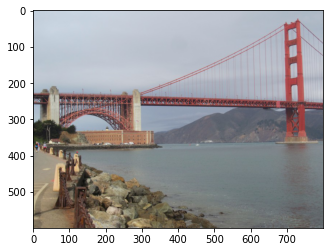

The most likely landmarks are: 1) Golden Gate Bridge  2) Forth Bridge  3) Brooklyn Bridge  


In [78]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show(img)
    
    result="The most likely landmarks are: "
    y = 1
    for x in np.nditer(predicted_landmarks):
        result += str(y)+") "+class_names[x]+"  " 
        y += 1
    print(result)    
# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

The model predicted three (3) out of the five (5) images I supplied to it. Of the five, two (2) were of images that the model was not trained to recognize (whitehouse and tower of london). 

The model correctly recogized the three other images. Note that all five images are high quality, stock photos that were likely easy for the model to intepret. 

The model appears to work as expected. 

Areas of improvement can include:
>- The use of more classes such as the white house and the lower of london and corresponding images
>- The use of a more efficient algorith to perform transfer learning on. the VGG16 model has a large number of weights and I frequently ran out of gpu memory. 
>- The use of better memory management techniques. 
>- A more customized dense layer
>- The use of noise, distortion, and blurring artifacts during the preprocessing of training images

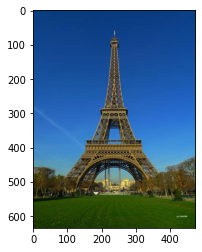

The most likely landmarks are: 1) Eiffel Tower  2) Vienna City Hall  3) Terminal Tower  


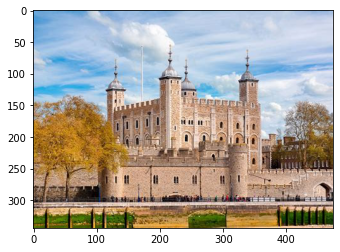

The most likely landmarks are: 1) Vienna City Hall  2) Edinburgh Castle  3) Terminal Tower  


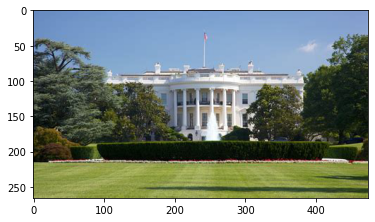

The most likely landmarks are: 1) Central Park  2) Temple of Heaven  3) Niagara Falls  


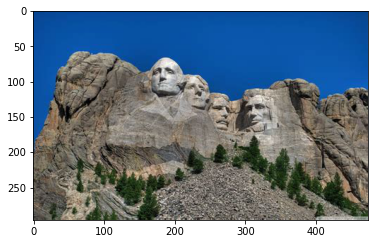

The most likely landmarks are: 1) Mount Rushmore National Memorial  2) Externsteine  3) Banff National Park  


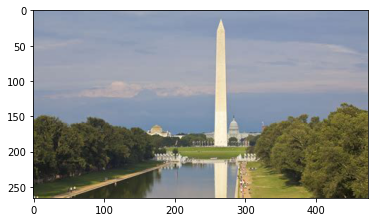

The most likely landmarks are: 1) Washington Monument  2) Terminal Tower  3) Taj Mahal  


In [84]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

image_dir = 'images/implement/'
images = ['eiffel_tower.jpg',
          'tower_of_london.jpg',
          'whitehouse.jpg',
          'mount_rushmore.jpg',
          'washington_monument.jpg'
         ]

for image in images:
    image_path = image_dir + image
    suggest_locations(image_path)

In [83]:
class_names

['Haleakala National Park',
 'Mount Rainier National Park',
 'Ljubljana Castle',
 'Dead Sea',
 'Wroclaws Dwarves',
 'London Olympic Stadium',
 'Niagara Falls',
 'Stonehenge',
 'Grand Canyon',
 'Golden Gate Bridge',
 'Edinburgh Castle',
 'Mount Rushmore National Memorial',
 'Kantanagar Temple',
 'Yellowstone National Park',
 'Terminal Tower',
 'Central Park',
 'Eiffel Tower',
 'Changdeokgung',
 'Delicate Arch',
 'Vienna City Hall',
 'Matterhorn',
 'Taj Mahal',
 'Moscow Raceway',
 'Externsteine',
 'Soreq Cave',
 'Banff National Park',
 'Pont du Gard',
 'Seattle Japanese Garden',
 'Sydney Harbour Bridge',
 'Petronas Towers',
 'Brooklyn Bridge',
 'Washington Monument',
 'Hanging Temple',
 'Sydney Opera House',
 'Great Barrier Reef',
 'Monumento a la Revolucion',
 'Badlands National Park',
 'Atomium',
 'Forth Bridge',
 'Gateway of India',
 'Stockholm City Hall',
 'Machu Picchu',
 'Death Valley National Park',
 'Gullfoss Falls',
 'Trevi Fountain',
 'Temple of Heaven',
 'Great Wall of China',